# Distillation via x0 prediction 

## Imports

In [1]:
from util_x0 import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2



c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


## Load Models with default 1024 steps


In [ ]:
config_path=f"{cwd}/models/configs/cin256-v2-x0_1024.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

teacher = create_models(config_path, model_path, student=False)

Test teacher:

In [ ]:
config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

teacher2 = create_models(config_path, model_path, student=False)

In [ ]:
xc = torch.tensor([992])
timesteps =  400
teacher.num_timesteps=timesteps
c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
img, x0, x_T_copy = teacher.progressive_denoising(cond=c, shape=[3, 64, 64], verbose=True, callback=None, quantize_denoised=False,
                              img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
                              score_corrector=None, corrector_kwargs=None, batch_size=1, x_T=None, start_T=None,
                              log_every_t=None)

# Custom Schedule, Important

In [ ]:
# ADD TIMESTEPS=... TO CREATE_MODELS
# teacher = create_models(config_path, model_path, student=False, timesteps=timesteps)

# Teacher predicting in steps

In [1]:
from util_x0 import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/cin256-v2-x0_1024.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

teacher = create_models(config_path, model_path, student=False, timesteps=1024)


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [2]:
image, x_T_copy, class_prompt = generate(teacher, steps=1024, class_prompt=992)


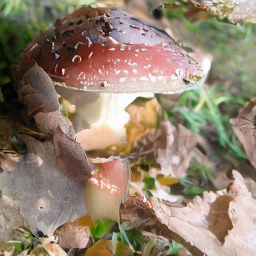

In [3]:
image

# Training student on teacher 1024 -> 512

In [2]:
from util_x0 import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/cin256-v2-x0_1024.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

teacher = create_models(config_path, model_path, student=False, timesteps=1024)
student = create_models(config_path, model_path, student=False, timesteps=512)




c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(
100%|██████████| 2/2 [00:08<00:00,  4.33s/it, epoch_loss=1.1]  


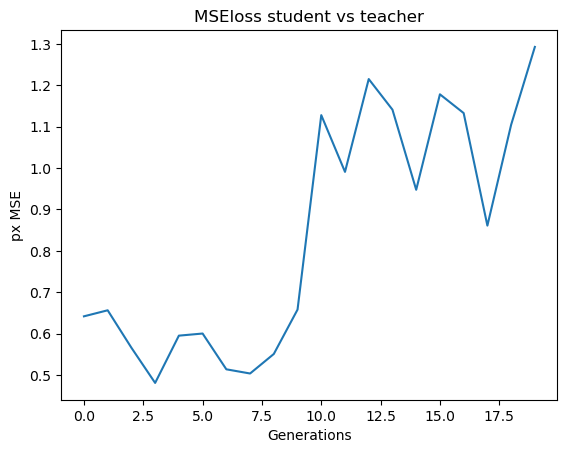

In [5]:
generations = 2
steps = 20


NUM_CLASSES = 1000
generations = generations
intermediate_generation = generations // 5
ddim_steps_teacher = steps
ddim_steps_student = int(ddim_steps_teacher / 2)
TEACHER_STEPS = 2
STUDENT_STEPS = 1
updates = int(ddim_steps_teacher / TEACHER_STEPS)
averaged_losses = []
teacher_samples = list()
criterion = nn.MSELoss()
instance = 0
generation = 0



optimizer, scheduler = get_optimizer(student, iterations=generations*ddim_steps_student, lr=0.0000000001)

a_t = np.linspace(0, 1, updates)

all_losses = []
ets = []
with torch.no_grad():
    with student.ema_scope():
            
            with tqdm.tqdm(torch.randint(0, NUM_CLASSES, (generations,))) as tepoch:
                for i, class_prompt in enumerate(tepoch):
                    generation += 1
                    losses = []  

                    xc = torch.tensor([class_prompt])
                    c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
                    c_student = student.get_learned_conditioning({student.cond_stage_key: xc.to(teacher.device)})
                    img = None
                    
                    for steps in range(updates):          
                                instance += 1
                                img, x0, x_T_copy = teacher.iterative_progressive_denoising(cond=c, shape=[3, 64, 64], verbose=True, callback=None, quantize_denoised=False,
                                    img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
                                    score_corrector=None, corrector_kwargs=None, batch_size=1, x_T=img, start_T=steps*2,
                                    log_every_t=None, keep_intermediates=False)   
                                

                                with torch.enable_grad():
                                    
                                    optimizer.zero_grad()
                                    img_student, x0_student, x_T_copy, a_t = student.iterative_progressive_denoising_student(cond=c_student, shape=[3, 64, 64], verbose=True, callback=None, quantize_denoised=False,
                                        img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
                                        score_corrector=None, corrector_kwargs=None, batch_size=1, x_T=x_T_copy, start_T=steps*1,
                                        log_every_t=None, keep_intermediates=False)   
                                    

                                    loss = max(torch.log((1- (a_t **2)) / a_t** 2), 1) * criterion(x0_student, x0)
                                    # math.log(a_t**2 / (1-a_t) **2) * 
                                           
                                    loss.backward()
                                    
                                    optimizer.step()
                                    scheduler.step()
                                    losses.append(loss.item())
                                    # if session != None:
                                    #     session.log({"intermediate_loss":loss.item()})

                            

                            # del samples_ddim, samples_ddim_student, teacher_intermediate, student_intermediate, x_T_copy, a_t, pred_x0_student
                            # torch.cuda.empty_cache()

                    # with torch.no_grad():
                    #     if generation > 2 and generation % intermediate_generation == 0:
                    #         save_model(sampler_student, optimizer, scheduler, name=f"intermediate_{instance}", steps=ddim_steps_student, run_name=run_name)
                    #         images, grid = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 6, 8, 10, 16, 20, 32, 64, 128])
                    #         images = wandb.Image(grid, caption=f"{instance} steps, left: Teacher, right: Student")
                    #         wandb.log({"Intermediate": images})
                    
                    
                    
                    all_losses.extend(losses)
                    # print(scheduler.get_last_lr())
                    averaged_losses.append(sum(losses) / len(losses))
                    # if session != None:
                    #     session.log({"generation_loss":averaged_losses[-1]})
                    tepoch.set_postfix(epoch_loss=averaged_losses[-1])
                    torch.cuda.empty_cache()
                    # if early_stop == True and i > 1:
                    #     if averaged_losses[-1] > (10*losses[-2]):
                    #         print(f"Early stop initiated: Prev loss: {round(averaged_losses[-2], 5)}, Current loss: {round(averaged_losses[-1], 5)}")
                    #         plt.plot(range(len(averaged_losses)), averaged_losses, label="MSE LOSS")
                    #         plt.xlabel("Generations")
                    #         plt.ylabel("px MSE")
                    #         plt.title("MSEloss student vs teacher")
                    #         plt.show()
                                

                                                        
plt.plot(range(len(all_losses)), all_losses, label="MSE LOSS")
plt.xlabel("Generations")
plt.ylabel("px MSE")
plt.title("MSEloss student vs teacher")
plt.show()
